# Python Tutorial

### Nov 15, 2022

# 1. Multi-armed Bandit Example : $\varepsilon$-greedy K-bandit problem

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

In [4]:
class eps_bandit:
    '''
    K: number of arms
    eps: probability of random action between 0 and 1
    T: number of steps
    mu: array of mean values of each arm's reward
    '''
    
    def __init__(self, K, eps, T, mu):
        self.K = K
        self.eps = eps
        self.T = T        
        self.n = 0 # Step count       
        self.K_n = np.zeros(self.K) # Step count for each arm

        self.cum_reward = 0
        self.reward = np.zeros(self.T)
        self.K_reward = np.zeros(self.K)
        self.mu = mu

    def pull(self):
        p = np.random.rand()
        if self.n == 0:
            a = np.random.choice(self.K)
        elif p < self.eps:
            
            a = np.random.choice(self.K) # Randomly select an action
        else:           
            a = np.argmax(self.K_reward) # Take greedy action
            
        reward = np.random.normal(self.mu[a], 1) # normal distribution with std 1
        
        # Update counts
        self.n += 1
        self.K_n[a] += 1
        
        # Update total average reward
        self.cum_reward += reward
        
        # Update results for a_K
        self.K_reward[a] += (reward - self.K_reward[a]) / self.K_n[a]
        
    def run(self):
        for i in range(self.T):
            self.pull()
            self.reward[i] = self.cum_reward
            
    def reset(self):
        # Resets the collected history
        self.n = 0
        self.K_n = np.zeros(self.K)
        self.cum_reward = 0
        self.reward = np.zeros(self.T)
        self.k_reward = np.zeros(self.K)

[2.9807642  1.68482974 2.4809319  2.39211752 0.34317802 2.72904971
 2.43857224 1.0596779  2.39804426 1.73799541]
episode 10.
episode 20.
episode 30.
episode 40.
episode 50.
episode 60.
episode 70.
episode 80.
episode 90.
episode 100.


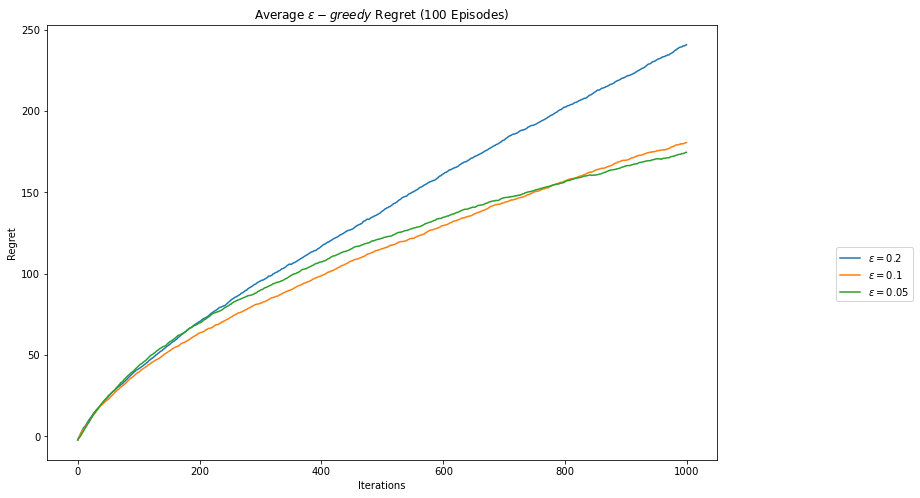

In [5]:
K = 10
T = 1000
np.random.seed(123)
mu = np.random.randint(3, size=K) + np.random.random(K)
print(mu)
max_reward = np.max(mu)
max_rewards = np.array(range(T)) * max_reward #maximum possible cumulative reward at time t

eps_2_rewards = np.zeros(T)
eps_1_rewards = np.zeros(T)
eps_05_rewards = np.zeros(T)

eps_2_selection = np.zeros(K)
eps_1_selection = np.zeros(K)
eps_05_selection = np.zeros(K)

episodes = 100
# Run experiments
for i in range(episodes):
    if i%10==9:
        print(f'episode {i+1}.')
    # Initialize bandits
    eps_2 = eps_bandit(K, 0.2, T, mu)    
    eps_1 = eps_bandit(K, 0.1, T, mu)
    eps_05 = eps_bandit(K, 0.05, T, mu)
    
    # Run experiments
    eps_2.run()
    eps_1.run()
    eps_05.run()

    eps_2_rewards+=(eps_2.reward - eps_2_rewards) / (i + 1)
    eps_1_rewards+=(eps_1.reward - eps_1_rewards) / (i + 1)
    eps_05_rewards+=(eps_05.reward - eps_05_rewards) / (i + 1)
    
    # Average actions per episode
    eps_2_selection+=(eps_2.K_n - eps_2_selection) / (i + 1)
    eps_1_selection+=(eps_1.K_n - eps_1_selection) / (i + 1)
    eps_05_selection+=(eps_05.K_n - eps_05_selection) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(max_rewards - eps_2_rewards, label="$\epsilon=0.2$")
plt.plot(max_rewards - eps_1_rewards, label="$\epsilon=0.1$")
plt.plot(max_rewards - eps_05_rewards, label="$\epsilon=0.05$")

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Regret")
plt.title(f"Average $\epsilon-greedy$ Regret ({episodes} Episodes)")
plt.show()

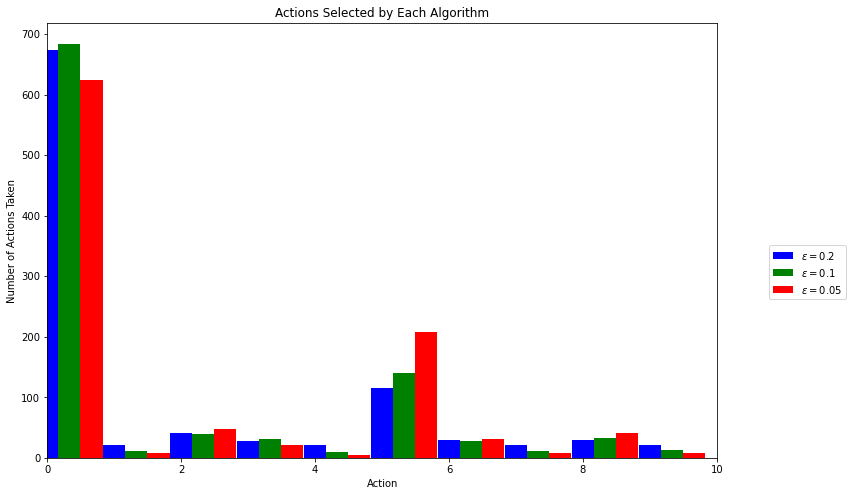

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0.2$,67.312,2.179,4.130,2.734,2.073,11.548,2.927,2.099,2.861,2.137
$\epsilon=0.1$,68.414,1.127,4.000,3.153,0.998,13.993,2.778,1.065,3.231,1.241
$\epsilon=0.05$,62.347,0.843,4.735,2.155,0.520,20.817,3.063,0.742,4.025,0.753


In [6]:
bins = np.linspace(0, K-1, K)

plt.figure(figsize=(12,8))
plt.bar(bins, eps_2_selection, 
        width = 0.33, color='b', 
        label="$\epsilon=0.2$")
plt.bar(bins+0.33, eps_1_selection,
        width=0.33, color='g', 
        label="$\epsilon=0.1$")
plt.bar(bins+0.66, eps_05_selection, 
        width=0.33, color='r',
        label="$\epsilon=0.05$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,K])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([eps_2_selection, eps_1_selection,
                   eps_05_selection]) / T * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0.2$', 
    '$\epsilon=0.1$', '$\epsilon=0.05$'],
                 columns=["a = " + str(x) for x in range(0, K)])
print("Percentage of actions selected:")
df

# 7. Multi-armed Bandit Example : Explore-then-Commit (ETC)

In [9]:
class etc_bandit:
    '''
    K: number of arms
    m: exploration parameter
    T: number of steps
    mu: array of mean values of each arm's reward
    '''
    
    def __init__(self, K, m, T, mu):
        self.K = K
        self.m = m
        self.T = T        
        self.n = 0 # Step count       
        self.K_n = np.zeros(self.K) # Step count for each arm

        self.cum_reward = 0
        self.reward = np.zeros(self.T)
        self.K_reward = np.zeros(self.K)
        self.mu = mu
        self.selected = 0

    def pull(self):
        
        if self.n < self.m*self.K:
            a = self.n % self.K
        
        elif self.n == self.m*self.K:
            a = np.argmax(self.K_reward)
            self.selected = a
        
        else:
            a = self.selected

        # Update counts
        self.n += 1
        self.K_n[a] += 1

        reward = np.random.normal(self.mu[a], 1) # normal distribution with std 1

        # Update results for a_K
        self.K_reward[a] += (reward - self.K_reward[a]) / self.K_n[a]

        # Update total average reward
        self.cum_reward += reward
            
        
    def run(self):
        for i in range(self.T):
            self.pull()
            self.reward[i] = self.cum_reward
            
    def reset(self):
        # Resets the collected history
        self.n = 0
        self.K_n = np.zeros(self.K)
        self.cum_reward = 0
        self.reward = np.zeros(self.T)
        self.k_reward = np.zeros(self.K)

[2.9807642  1.68482974 2.4809319  2.39211752 0.34317802 2.72904971
 2.43857224 1.0596779  2.39804426 1.73799541]
episode 10.
episode 20.
episode 30.
episode 40.
episode 50.
episode 60.
episode 70.
episode 80.
episode 90.
episode 100.


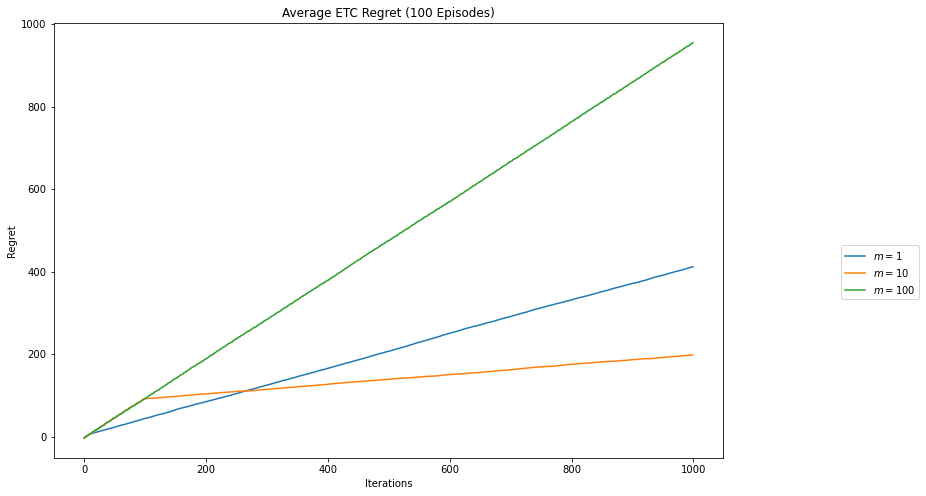

In [10]:
K = 10
T = 1000
np.random.seed(123)
mu = np.random.randint(3, size=K) + np.random.random(K)
print(mu)
max_reward = np.max(mu)
max_rewards = np.array(range(T)) * max_reward #maximum possible cumulative reward at time t

etc_1_rewards = np.zeros(T)
etc_10_rewards = np.zeros(T)
etc_100_rewards = np.zeros(T)

etc_1_selection = np.zeros(K)
etc_10_selection = np.zeros(K)
etc_100_selection = np.zeros(K)

episodes = 100
# Run experiments
for i in range(episodes):
    if i%10==9:
        print(f'episode {i+1}.')
    # Initialize bandits
    etc_1 = etc_bandit(K, 1, T, mu)    
    etc_10 = etc_bandit(K, 10, T, mu)
    etc_100 = etc_bandit(K, 100, T, mu)
    
    # Run experiments
    etc_1.run()
    etc_10.run()
    etc_100.run()

    etc_1_rewards+=(etc_1.reward - etc_1_rewards) / (i + 1)
    etc_10_rewards+=(etc_10.reward - etc_10_rewards) / (i + 1)
    etc_100_rewards+=(etc_100.reward - etc_100_rewards) / (i + 1)
    
    # Average actions per episode
    etc_1_selection+=(etc_1.K_n - etc_1_selection) / (i + 1)
    etc_10_selection+=(etc_10.K_n - etc_10_selection) / (i + 1)
    etc_100_selection+=(etc_100.K_n - etc_100_selection) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(max_rewards - etc_1_rewards, label="$m=1$")
plt.plot(max_rewards - etc_10_rewards, label="$m=10$")
plt.plot(max_rewards - etc_100_rewards, label="$m=100$")

plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Regret")
plt.title(f"Average ETC Regret ({episodes} Episodes)")
plt.show()

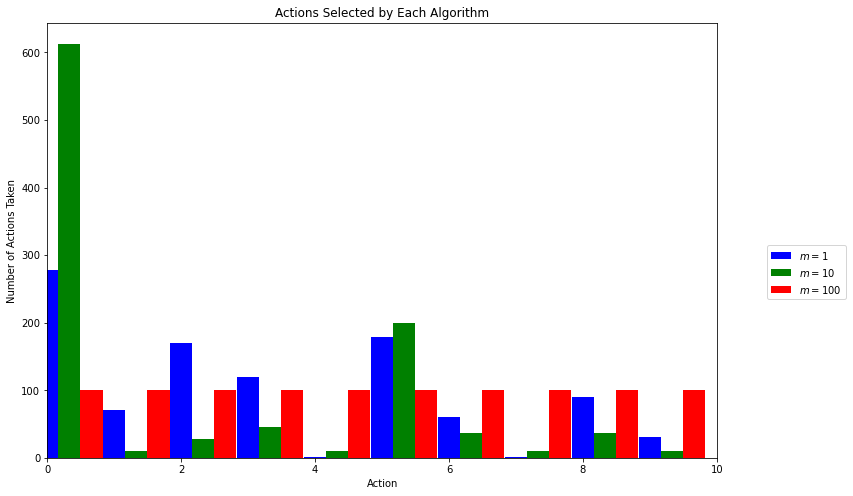

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$m=1$,27.82,7.03,16.93,11.98,0.1,17.92,6.04,0.1,9.01,3.07
$m=10$,61.30,1.00,2.80,4.60,1.0,19.90,3.70,1.0,3.70,1.00
$m=100$,10.00,10.00,10.00,10.00,10.0,10.00,10.00,10.0,10.00,10.00


In [11]:
bins = np.linspace(0, K-1, K)

plt.figure(figsize=(12,8))
plt.bar(bins, etc_1_selection, 
        width = 0.33, color='b', 
        label="$m=1$")
plt.bar(bins+0.33, etc_10_selection,
        width=0.33, color='g', 
        label="$m=10$")
plt.bar(bins+0.66, etc_100_selection, 
        width=0.33, color='r',
        label="$m=100$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,K])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([etc_1_selection, etc_10_selection,
                   etc_100_selection]) / T * 100
df = pd.DataFrame(opt_per, index=['$m=1$', 
    '$m=10$', '$m=100$'],
                 columns=["a = " + str(x) for x in range(0, K)])
print("Percentage of actions selected:")
df

* UCB, LinUCB on next session!